In [484]:
import numpy as np
import math
import os
import random
from matplotlib import pyplot as plt
import queue
import collections
import seaborn as sns
PAGE_SIZE = 4096                    # Page Size in Bytes
NP = 6                              # No. of processes in memory
F = 16                              # No. of Frames in physical memory
INVALID = -10
PID = 0                             # Used for Indexing into Frames
FRAME = 1                           # Used for Indexing into Frames
COMPLETED = 10                      # Process Status Flags
INCOMPLETE = 20                     #
# The following are page replacement algorithm types
FIFO_GLOBAL = 10
oldest_frame = 0
recent_frame=0
page_frequency={}
loc_oldest_frame = np.zeros(F).astype('int32')
phys_mem = np.full((F, 2), INVALID).astype('int32')
algos=["fifo","lru","rr","mru","lfu"]

In [485]:
def init_proc_queue():
    pq = queue.Queue(maxsize=NP)
    proc_queue = list(set((NP * np.random.random(20)).astype('int32')))
    random.shuffle(proc_queue)
    print(proc_queue)
    for pr in proc_queue:
        pq.put_nowait(pr)
    return(pq)

def readq(q):
    while True:
        try:
            yield q.get_nowait()
        except queue.Empty:
            break

In [486]:
def init_phys_mem():
    for i in range(F):
        #         initializing Physical memory to implement FIFO
        phys_mem[i, PID] = INVALID
        phys_mem[i, FRAME] = INVALID


def update_phys_mem(pid):
    for i in range(F):
        #         Updating physical memory of FIFO
        if phys_mem[i, PID] == pid:
            phys_mem[i, PID] = INVALID
            phys_mem[i, FRAME] = INVALID

In [487]:
def correct_refs(alist, cent, maxpg):
    if cent != 0:
        pgnum = int(cent / PAGE_SIZE)
        lh = (pgnum + 1) * PAGE_SIZE - 1
        ll = pgnum * PAGE_SIZE
    else:
        lh = maxpg * PAGE_SIZE
        ll = 0
    for i in range(alist.shape[0]):
        if alist[i] >= lh:
            alist[i] = lh - 1
        if alist[i] < ll:
            alist[i] = ll + 1
    return alist
def sim_process(M, sigma, outfile, lfrac=0.9):
    cur_page = int(M * np.random.random())  # Generate a random start page
    cur_locale = round(PAGE_SIZE * (cur_page + 0.5))  # Locality of reference
    sum_refs = 0
    list_locales = list()
    for count in range(M):
        page_frequency[cur_page]=0
        # random page address in memory.
        num_refs = int(512 + (PAGE_SIZE - 512) * np.random.random())
        sum_refs += num_refs
        list_locales.append(cur_page)
        num_loc = round(lfrac * num_refs)
        aref_list = np.random.normal(cur_locale, sigma * 300 + 100,
                                     num_loc)  # If siagma is less, it stays less within that locality of reference
        # if sigma more, it may vary more
        aref_list = correct_refs(aref_list, cur_locale, M)
        aref_list = aref_list.astype('int32')
        cur_page = int(M * np.random.random())
        cur_locale = round(PAGE_SIZE * (cur_page + 0.5))
        num_trans = round((1 - lfrac) * num_refs)
        tref_list = np.random.random(num_trans) * cur_locale
        tref_list = correct_refs(tref_list, 0, M)
        tref_list = tref_list.astype('int32')
        np.append(aref_list, tref_list).tofile(outfile, sep='\n')
        outfile.write('\n')

    return list_locales, sum_refs

In [488]:
def get_oldest_frame(pr):
    global oldest_frame
    rv = oldest_frame
    oldest_frame += 1
    if oldest_frame == F:
        oldest_frame = 0
    return rv

    return INVALID
def getFifoFrame(fr_num, pnum, pr):
    while fr_num < F:
        if phys_mem[fr_num, PID] == pr and phys_mem[fr_num, FRAME] == pnum:
            break
        else:
            fr_num += 1
    return fr_num


def getLruFrame(fr_num, pnum, pr):
    global phys_mem
    while fr_num < F:
        if phys_mem[fr_num, PID] == pr and phys_mem[fr_num, FRAME] == pnum:
            temp = phys_mem[fr_num]
            phys_mem = np.delete(phys_mem, fr_num, axis=0)
            phys_mem = np.concatenate([phys_mem, temp.reshape(1, -1)], axis=0)
            break
        else:
            fr_num += 1
    return fr_num


def getMRUFrame(fr_num, pnum, pr):
    while fr_num < F:
        if phys_mem[fr_num, PID] == pr and phys_mem[fr_num, FRAME] == pnum:
            break
        else:
            fr_num += 1
    recent_frame=fr_num
    return fr_num


def getRRFrame(fr_num, pnum, pr):
    while fr_num < F:
        if phys_mem[fr_num, PID] == pr and phys_mem[fr_num, FRAME] == pnum:
            break
        else:
            fr_num += 1
    return fr_num


def getLFUFrame(fr_num, pnum, pr):
    while fr_num < F:
        if phys_mem[fr_num, PID] == pr and phys_mem[fr_num, FRAME] == pnum:
            page_frequency[pnum]+=1
            break
        else:
            fr_num += 1
    return fr_num

In [489]:
def gen_pagefault(pgnum, pr):
    fr_num = 0
    while fr_num < F and phys_mem[fr_num, FRAME] >= 0:
        fr_num += 1
    if fr_num >= F:
        return INVALID
    phys_mem[fr_num, FRAME] = pgnum
    phys_mem[fr_num, PID] = pr
    recent_frame=fr_num
    if pgnum not in page_frequency:
        page_frequency[pgnum]=1
    else:
        page_frequency[pgnum]+=1
    return fr_num

In [490]:
def page_replace(pgnum, pr):
    global phys_mem
    temp = np.array([pr, pgnum])
    phys_mem = np.delete(phys_mem, 0, axis=0)
    phys_mem = np.concatenate([phys_mem, temp.reshape(1, -1)], axis=0)
    return F-1


def page_replaceFIFO(pgnum, pr):
    cur_frame = get_oldest_frame(pr)
    phys_mem[cur_frame, PID] = pr
    phys_mem[cur_frame, FRAME] = pgnum
    return cur_frame

def page_replaceMRU(pgnum,pr):
    global phys_mem
    temp = np.array([pr, pgnum])
    phys_mem = np.delete(phys_mem, recent_frame, axis=0)
    phys_mem=np.insert(phys_mem,recent_frame,temp,axis=0)
    return recent_frame


def page_replaceRR(pgnum, pr):
    global phys_mem
    f_num=np.random.randint(F)
    temp = np.array([pr, pgnum])
    phys_mem = np.delete(phys_mem, f_num, axis=0)
    phys_mem=np.insert(phys_mem,f_num,temp,axis=0)
    return f_num


def page_replaceLFU(pgnum,pr):
    global phys_mem
    temp_freq=page_frequency.copy()
    flag="not_found"
    while flag =="not_found":
        try:
            min_freq=min(temp_freq,key=temp_freq.get)
            frame_loc=np.where(phys_mem[:,FRAME]==min_freq)[0][0]
            temp = np.array([pr,pgnum])
            phys_mem = np.delete(phys_mem, frame_loc, axis=0)
            phys_mem=np.insert(phys_mem,frame_loc,temp,axis=0)
            page_frequency[min_freq]=0
            flag="found"
        except:
            min_freq=min(temp_freq,key=temp_freq.get)
            del(temp_freq[min_freq])
            flag="not_found"

    return frame_loc


In [491]:
def get_pageframe(pnum, pr, algo=None):

    # Trying to get a page Hit below
    fr_num = 0
    if algo == "lru":
        fr_num = getLruFrame(fr_num, pnum, pr)
    elif algo == "fifo":
        fr_num = getFifoFrame(fr_num, pnum, pr)
    elif algo == "mru":
        fr_num = getLruFrame(fr_num, pnum, pr)
    elif algo == "rr":
        fr_num = getRRFrame(fr_num, pnum, pr)
    elif algo == "lfu":
        fr_num = getLFUFrame(fr_num, pnum, pr)        

    # This indicates Page Hit.
    if fr_num < F:
        return fr_num * PAGE_SIZE, 0

    # This tries to find page fault if occured.
    fr_num = gen_pagefault(pnum, pr)

    if fr_num >= 0:
        return fr_num * PAGE_SIZE, 1

    # This is for page replacement based on algorith choosen
    if algo == "lru":
        fr_num = page_replace(pnum, pr)
    elif algo == "fifo":
        fr_num = page_replaceFIFO(pnum, pr)
    elif algo=="rr":
        fr_num=page_replaceRR(pnum,pr)
    elif algo=="mru":
        fr_num=page_replaceMRU(pnum,pr)
    elif algo=="lfu":
        fr_num=page_replaceLFU(pnum,pr)

    if fr_num >= 0:
        return fr_num * PAGE_SIZE, 2
    return INVALID, 0

In [492]:
def mem_manager(infile, outfile, pid, algo=None):
    #    num_faults = 0
    # Read a number of address references, i.e., execute the process
    # partially (or fully, if the number generated is > process size)
    num_addr = 512 + int(4096 * np.random.random())
    idx = 0
    while idx < num_addr:
        addr_ref = infile.readline().strip()
        if addr_ref == '':
            break
        addr_ref = int(addr_ref)
        pg_num = int(addr_ref / PAGE_SIZE)
        pg_offset = addr_ref % PAGE_SIZE
        pg_base, pg_fault = get_pageframe(pg_num, pid, algo)

        if pg_base >= 0:
            phys_addr = pg_base + pg_offset
            outfile.write(str(addr_ref) + ',' + str(phys_addr) + ','
                          + str(pg_fault) + '\n')  # Saving the logical add, physical add and faults

            if pg_fault == 0:
                pr_timing[pid] += IN_MEMORY
            elif pg_fault == 1:
                pr_timing[pid] += MEM_FAULT
            else:
                pr_timing[pid] += PAGE_REPLACE

        else:
            print(idx)
            return INVALID
        idx += 1

    if idx >= num_addr:
        return INCOMPLETE
    return COMPLETED

In [493]:
def print_phys_mem():
    print('{:^10s} {:^6s} {:^6s}'.format('Frame', 'PID', 'Page No.'))
    print('{:^10s} {:^6s} {:^6s}'.format('-----', '---', '--------'))
    for i in range(F):
        if phys_mem[i, PID] != INVALID:
            print('{:^10d} {:^6d} {:^6d}'.format(i, phys_mem[i, PID],
                                                 phys_mem[i, FRAME]))
        else:
            print('Free Frame: ', i)
    print('_____________________________________________________________')


In [494]:
pr_size = np.zeros(NP, dtype='int32')
def create_simulation():
    for p in range(NP):
        fname = 'AR_' + '{:02d}'.format(p) + '.txt'
        op = open(fname, 'w')
        npg = int(np.random.normal(10, 2.5))
        nsig = int(5 * np.random.random())
        print(f'Process {p} requires {npg} pages and has a quality {nsig}')
        pg_seq, pr_size[p] = sim_process(npg, nsig, op)
        print(pg_seq, pr_size[p])
        op.write('\n')
        op.close()
        print('Written process ', p, 'to ', fname)

In [495]:
int(5 * np.random.random())

0

In [496]:
create_simulation()

Process 0 requires 8 pages and has a quality 2
[1, 0, 3, 0, 7, 4, 4, 2] 17438
Written process  0 to  AR_00.txt
Process 1 requires 12 pages and has a quality 1
[2, 5, 1, 1, 10, 10, 6, 6, 5, 1, 7, 11] 25877
Written process  1 to  AR_01.txt
Process 2 requires 8 pages and has a quality 3
[0, 7, 3, 1, 1, 0, 1, 3] 16437
Written process  2 to  AR_02.txt
Process 3 requires 14 pages and has a quality 4
[2, 6, 3, 6, 13, 12, 10, 4, 3, 12, 7, 2, 0, 1] 34333
Written process  3 to  AR_03.txt
Process 4 requires 13 pages and has a quality 0
[2, 12, 1, 10, 4, 9, 9, 4, 0, 9, 4, 6, 3] 29399
Written process  4 to  AR_04.txt
Process 5 requires 12 pages and has a quality 4
[0, 4, 2, 10, 2, 1, 4, 4, 3, 10, 7, 11] 27684
Written process  5 to  AR_05.txt


In [497]:
# algo = input("Enter the algorithm to use")

In [498]:
for algo in algos:
    init_phys_mem()
    oldest_frame = 0
    recent_frame=0
    pr_que = init_proc_queue()
    pr_timing = np.zeros(F).astype('int32')
    IN_MEMORY = 1
    MEM_FAULT = 50
    PAGE_REPLACE = 100

    # Open necessary files
    infiles = list()
    outfiles = list()
    for i in range(NP):
        fname = 'AR_{:02d}.txt'.format(i)
        outname = 'AR_{:02}_{}_out.txt'.format(i, algo)

        if os.access(fname, os.R_OK):
            print(f'Reading Process from {fname}')
            infiles.append(open(fname, 'r'))
        else:
            print(f'Cannot open {fname} for reading')
        outfiles.append(open(outname, 'w'))

    # Map logical into physical addresses and keep track of page faults
    for pr in readq(pr_que):
        rv = mem_manager(infiles[pr], outfiles[pr], pr, algo=algo)
        if rv == INVALID:
            print('Memory overflow error')
            break
        if rv == INCOMPLETE:
            pr_que.put_nowait(pr)
        else:
            print(f'Process {pr} (Size: {pr_size[pr]} Bytes) completed; \
            removing from queue')
            print(f'Time taken: {pr_timing[pr]}')
            slow = (pr_timing[pr] - pr_size[pr]) * 100.0 / pr_size[pr]
            print('Slow down by {:.2f}%'.format(slow))
            print_phys_mem()
            update_phys_mem(pr)

    #        print('Current Status of Physical Memory')
    #        print_phys_mem()

    # Close all files
    for i in range(NP):
        infiles[i].close()
        outfiles[i].close()

[1, 0, 5, 2, 4, 3]
Reading Process from AR_00.txt
Reading Process from AR_01.txt
Reading Process from AR_02.txt
Reading Process from AR_03.txt
Reading Process from AR_04.txt
Reading Process from AR_05.txt
Process 0 (Size: 17438 Bytes) completed;             removing from queue
Time taken: 20307
Slow down by 16.45%
Process 2 (Size: 16437 Bytes) completed;             removing from queue
Time taken: 19357
Slow down by 17.76%
Process 5 (Size: 27684 Bytes) completed;             removing from queue
Time taken: 33124
Slow down by 19.65%
Process 1 (Size: 25877 Bytes) completed;             removing from queue
Time taken: 33990
Slow down by 31.35%
Process 4 (Size: 29399 Bytes) completed;             removing from queue
Time taken: 37065
Slow down by 26.08%
Process 3 (Size: 34333 Bytes) completed;             removing from queue
Time taken: 43389
Slow down by 26.38%
[1, 2, 3, 5, 4, 0]
Reading Process from AR_00.txt
Reading Process from AR_01.txt
Reading Process from AR_02.txt
Reading Process f

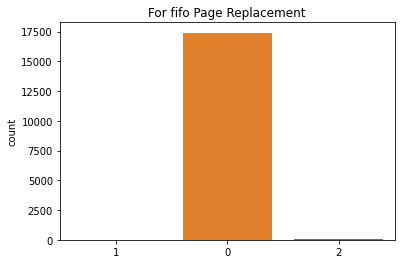

Counter({'0': 17407, '2': 27, '1': 4})


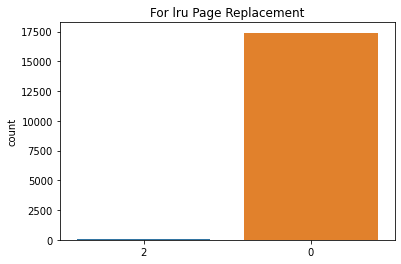

Counter({'0': 17410, '2': 28})


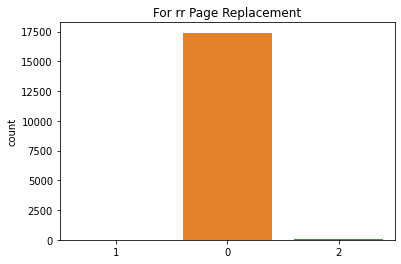

Counter({'0': 17407, '2': 29, '1': 2})


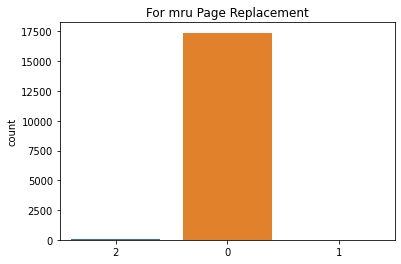

Counter({'0': 17395, '2': 37, '1': 6})


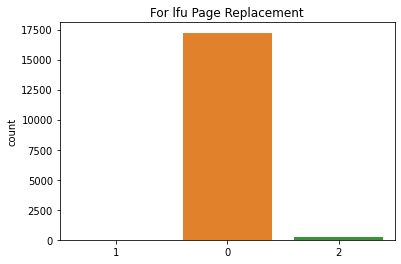

Counter({'0': 17233, '2': 203, '1': 2})


In [499]:
for algo in algos:
    file_name='AR_00_{}_out.txt'.format(algo)
    file=open(file_name,'r')
    data=file.read()
    datas=np.array(data.split('\n'))
    faults=[data[-1] for data in datas[:-1]]
    plt.title("For {} Page Replacement".format(algo))
    sns.countplot(x=faults)
    plt.show()
    print(collections.Counter(faults))